In [1]:
import math
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyproj import Proj, transform

In [2]:
# Retrieve data
barycentre_dep = pd.read_csv("./data/centre_departement.csv", sep=";")
I = Image.open('./assets/france-gray.png')
IColor = Image.open('./assets/france.png')

# Convigure pyproj to convert GPS WGS84 coordinate to lambert 93 coordinate
# https://geofree.fr/gf/coordinateconv.asp#listSys
# https://fr.wikipedia.org/wiki/Projection_conique_conforme_de_Lambert
xy = Proj(projparams='epsg:2154')
latlon = Proj(projparams='epsg:4326')

In [3]:
# Bottom right corner
origin1_lon = "4°58'12\" O"
origin1_lat = "42°18'14.4\" N" 
origin1_x, origin1_y = 0, 0

# Top left corner
origin2_lon = "8°38'9.6\" E"
origin2_lat = "51°4'30\" N"
origin2_x, origin2_y = I.size

In [4]:
def convert_todeg(deg_str):
    """
        Convert deg°min'sec" to deg,deeeg°
    """
    deg, rest = deg_str.split('°')
    min, rest = rest.split('\'')
    sec, rest = rest.split('\"')
    sign = -1 if 'O' in rest or 'S' in rest else 1
    return sign*(float(deg)+float(min)/60+float(sec)/3600)

origin1_lamb_x, origin1_lamb_y = transform(latlon, xy, convert_todeg(origin1_lat), convert_todeg(origin1_lon))
origin2_lamb_x, origin2_lamb_y = transform(latlon, xy, convert_todeg(origin2_lat), convert_todeg(origin2_lon))
coef2X = (origin2_x - origin1_x)/(origin2_lamb_x - origin1_lamb_x)
coef2Y = (origin2_y - origin1_y)/(origin2_lamb_y - origin1_lamb_y)

# >> Empiric parameters
off_set_x = -46
off_set_y = -6
compenseX = lambda x, y: int(math.tanh(x/200)*40-40) + int(math.tanh((x-1100)/200)*40+40)
compenseY = lambda x, y: int(-math.tanh((y-1000)/200)*40-40) + int(-math.tanh((x+70)/200)*100+100)
# <<
lamb2coordX = lambda x: (x - origin1_lamb_x)*coef2X + origin1_x + off_set_x
lamb2coordY = lambda y: I.size[1] - (y - origin1_lamb_y)*coef2Y + origin1_y + off_set_y

def deg2coord(lat, lon): 
    """
        Convert deg°min'sec" to (x, y) on the plot
    """
    lamb = transform(latlon, xy, convert_todeg(lat), convert_todeg(lon))
    coordX, coordY = int(lamb2coordX(lamb[0])), int(lamb2coordY(lamb[1]))

    # Need compensation to adjust lambert projection on the map
    return coordX + compenseX(coordX, coordY), coordY + compenseY(coordX, coordY)

C:\Users\paull\AppData\Local\Temp/ipykernel_26172/3299320332.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  origin1_lamb_x, origin1_lamb_y = transform(latlon, xy, convert_todeg(origin1_lat), convert_todeg(origin1_lon))
C:\Users\paull\AppData\Local\Temp/ipykernel_26172/3299320332.py:12: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  origin2_lamb_x, origin2_lamb_y = transform(latlon, xy, convert_todeg(origin2_lat), convert_todeg(origin2_lon))


In [5]:
X, Y = [], []
lat = barycentre_dep["LAT"]
lon = barycentre_dep["LON"]
for i in range(len(barycentre_dep)):
    coord = deg2coord(lat[i], lon[i])
    X.append(coord[0])
    Y.append(coord[1])

barycentre_dep['X'] = X
barycentre_dep['Y'] = Y

barycentre_dep.head()

C:\Users\paull\AppData\Local\Temp/ipykernel_26172/3299320332.py:29: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lamb = transform(latlon, xy, convert_todeg(lat), convert_todeg(lon))


,DEP,AREA,LON,LAT,X,Y
0,01,5 785,"5°20'56"" E","46°05'58""",802,588
1,02,7 419,"3°33'30"" E","49°33'34""",657,186
2,03,7 380,"3°11'18"" E","46°23'37""",631,557
3,04,6 996,"6°14'38"" E","44°06'22""",885,809
4,05,5 689,"6°15'47"" E","44°39'49""",884,748


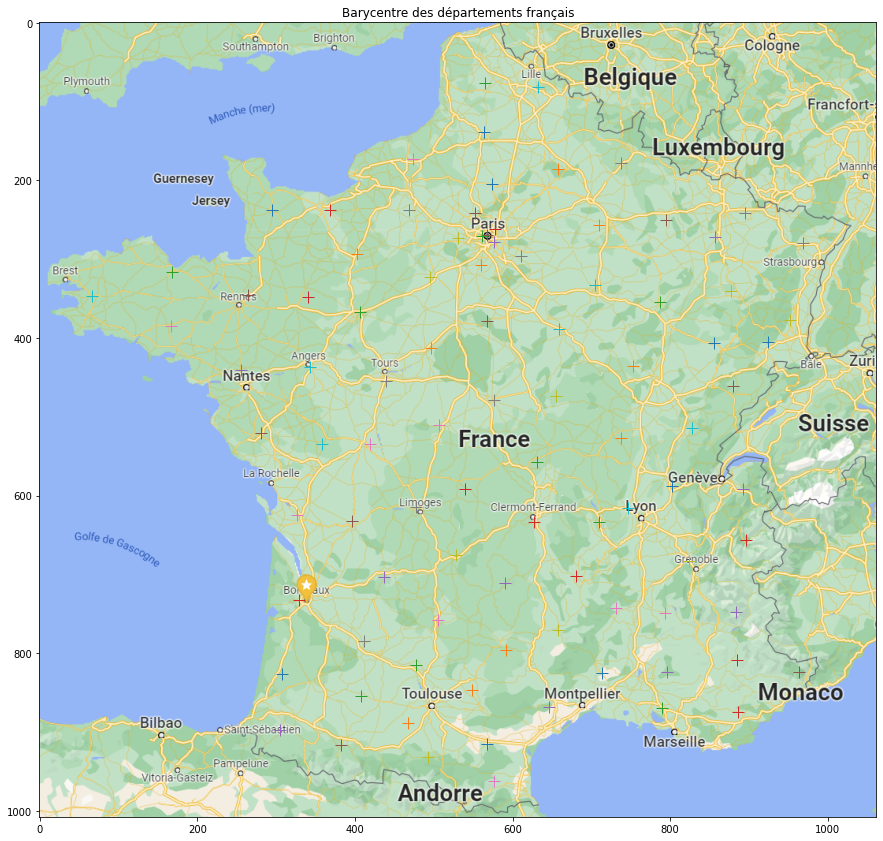

In [6]:
# Plot departement barycenters 
fig, ax = plt.subplots(1, 1, figsize=(15,15))
for dep in barycentre_dep.iloc:
    ax.plot(dep['X'], dep['Y'], marker='+', markersize=12)
    
    # find offset to center 75 Paris marker
    # x, y = deg2coord("48°51'24\"", "2°20'32\" E")
    # ax.plot(x-46, y, marker='+', markersize=12)

ax.set_title("Barycentre des départements français")
ax.imshow(IColor)
plt.show()

In [7]:
population = pd.read_csv("./data/population.csv", sep=";")
pop_iris = population[["DEP","P18_POP"]]
pop_dep = pop_iris.groupby(["DEP"]).sum().reset_index()
dep_list = list(pop_dep["DEP"])
dep_list = [ "0"+str(dep) if str(dep).isdigit() and int(dep) < 10 else str(dep) for dep in dep_list]
pop_dep["DEP"] = dep_list
pop_dep.loc[pop_dep["DEP"] == "33"]["P18_POP"].values[0]

C:\Users\paull\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (0,2,3,4,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1601842

In [9]:
wedding_2018 = pd.read_csv("./data/etatcivil2018_mar2018_csv/FD_MAR_2018.csv", sep=";")

value, count = np.unique(wedding_2018["DEPMAR"], return_counts=True)
wedding_per_dep = { value[i]: [count[i], int(barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]["AREA"].values[0].replace(' ','')), pop_dep.loc[pop_dep["DEP"] == value[i]]["P18_POP"].values[0], (barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['X'].values[0], barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['Y'].values[0])] for i in range(len(value)) if value[i].isdigit() and int(value[i]) < 100}
wedding_per_dep_small = { value[i]: [count[i], int(barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]["AREA"].values[0].replace(' ','')), pop_dep.loc[pop_dep["DEP"] == value[i]]["P18_POP"].values[0], (barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['X'].values[0], barycentre_dep.loc[barycentre_dep['DEP'] == value[i]]['Y'].values[0])] for i in range(len(value)) if value[i].isdigit() and int(value[i]) < 10}

# Exemple
key = "01"
print("Exemple:")
print(key, wedding_per_dep[key], sep=": ")
print("departement: [nb_mariage, dep_area(km²), dep_pop, (dep_x,dep_y)]")

C:\Users\paull\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Exemple:
01: [2248, 5785, 647632, (802, 588)]
departement: [nb_mariage, dep_area(km²), dep_pop, (dep_x,dep_y)]


In [10]:
wedding_2019 = pd.read_csv("./data/etatcivil2019_mar2019_csv/FD_MAR_2019.csv", sep=";")

value19, count19 = np.unique(wedding_2019["DEPMAR"], return_counts=True)
diff_wedding_per_dep = { value19[i]: [(count19[i]-count[i])/count[i]*100, int(barycentre_dep.loc[barycentre_dep['DEP'] == value19[i]]["AREA"].values[0].replace(' ','')), pop_dep.loc[pop_dep["DEP"] == value19[i]]["P18_POP"].values[0], (barycentre_dep.loc[barycentre_dep['DEP'] == value19[i]]['X'].values[0], barycentre_dep.loc[barycentre_dep['DEP'] == value19[i]]['Y'].values[0])] for i in range(len(value19)) if value19[i].isdigit() and int(value19[i]) < 100}

In [11]:
print("Nombre de mariage en 2018:", "\t", wedding_2018.size)
print("Nombre de mariage en 2019:", "\t", wedding_2019.size)
print("Différence:", "\t\t\t",  f"{100*(wedding_2019.size- wedding_2018.size)/wedding_2018.size:.2f}%")

Nombre de mariage en 2018: 	 4225230
Nombre de mariage en 2019: 	 4045320
Différence: 			 -4.26%


In [13]:
maxi, mini = 0, 0
dep_min, dep_max = "", ""
for key, val in zip(diff_wedding_per_dep.keys(), diff_wedding_per_dep.values()):
    if val[0] > maxi: 
        maxi = val[0]
        dep_max = key
    if val[0] < mini: 
        mini = val[0]
        dep_min = key

print("Valeur extreme:")
print(dep_min, ":", f"{mini:.2f}%")
print(dep_max, ":", f"{maxi:.2f}%")

Valeur extreme:
04 : -18.92%
89 : 5.95%


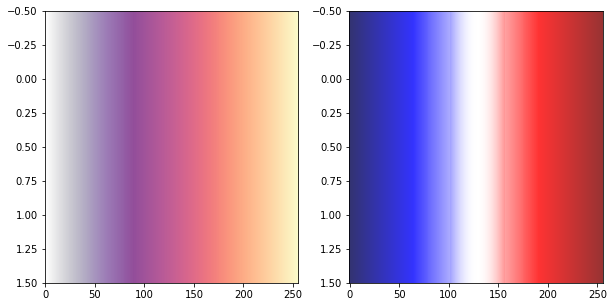

In [14]:
def twoD_Gaussian(c, yo, xo, sigma_x, sigma_y, ampl):
    x, y = c
    a = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    c = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    g = np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g * ampl


def transparent_cmap(cmap, alpha):
    # Copy colormap and set alpha values
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = alpha

    return mycmap


alpha = list(np.linspace(0,0.8,90))
alpha.extend([0.80]*(259-90))
mycmap_magma = transparent_cmap(plt.cm.magma, alpha)


alpha = [0.80]*102
alpha.extend(list(np.linspace(0.9,0,28)))
alpha.extend(list(np.linspace(0,0.9,27)))
alpha.extend([0.80]*102)
# mycmap_diverging = transparent_cmap(plt.cm.coolwarm, alpha)
mycmap_diverging = transparent_cmap(plt.cm.seismic, alpha)

gradient = np.linspace(0,1,256)
gradient = np.vstack((gradient, gradient))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(gradient, aspect='auto', cmap=mycmap_magma)
plt.subplot(122)
plt.imshow(gradient, aspect='auto', cmap=mycmap_diverging)
plt.show()

In [15]:
w, h = I.size
y, x = np.mgrid[0:h, 0:w]
z = np.zeros((x.shape[0], y.shape[1]))

n = 0
for i in range(len(z)):
    for j in range(len(z[i])):
        if n%1000 == 0:
            print('\r', f"{n*100/(w*h):0.2f}%"," "*20, end="\r")
        for wedding, area, pop, barycentre  in diff_wedding_per_dep.values():
            
            # sigma gaussien = rayon d'un disque d'air area
            # 68% de la distribution se situe à sigma de la moyenne (x,y)
            sigma = math.sqrt(area/3.1415) 
            dep_y, dep_x = barycentre
            if math.sqrt(((i-dep_x)**2+(j-dep_y)**2)) < 3*sigma: 
                z[i][j] += twoD_Gaussian((i,j), dep_y, dep_x, sigma, sigma, wedding)
        n+=1

In [16]:
np.save("./map-data/heatmap.npy", z)

In [17]:
# z = np.load("./map-data/heatmap-normalize-area.npy",z)
# for i in range(len(z)):
#     for j in range(len(z[i])):
#         z[i][j] = min(5e5, z[i][j])
# z = np.load("./map-data/heatmap-absolute.npy")

## Plots

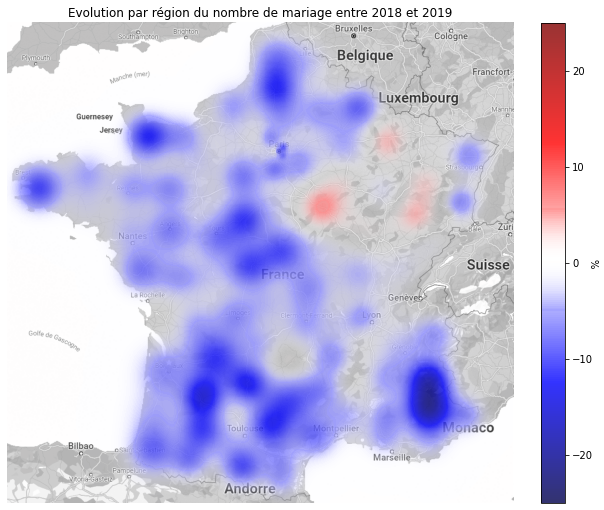

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("./map-data/heatmap-diff-1819.npy")

c = ax.pcolormesh(x, y , z, cmap=mycmap_diverging, vmin=-25, vmax=25)

cbar = plt.colorbar(c, ax=ax, fraction=0.043)
cbar.set_label('%', rotation=270)
ax.set_title("Evolution par région du nombre de mariage entre 2018 et 2019")
ax.imshow(I)
plt.axis('off')
plt.show()

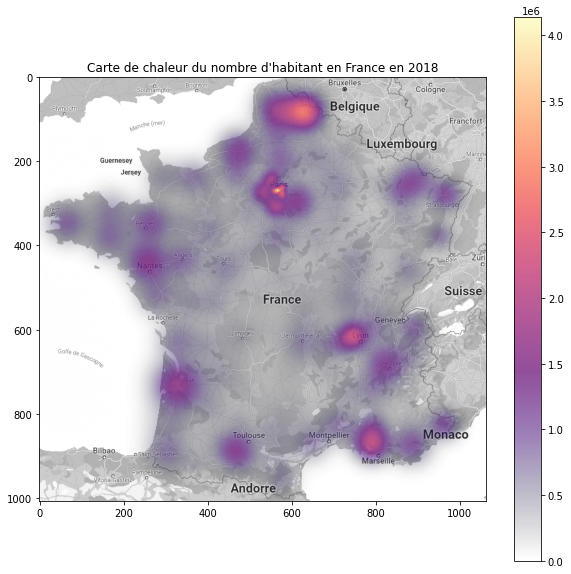

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("./map-data/heatmap-pop.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap_magma)
fig.colorbar(c, ax=ax)
ax.set_title("Carte de chaleur du nombre d'habitant en France en 2018")
ax.imshow(I)
plt.show()

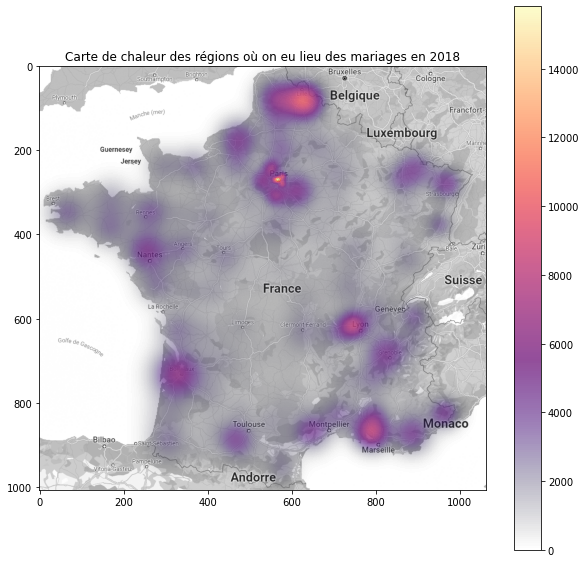

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("./map-data/heatmap-absolute-sigma-radius.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap_magma)
fig.colorbar(c, ax=ax)
ax.set_title("Carte de chaleur des régions où on eu lieu des mariages en 2018")
ax.imshow(I)
plt.show()

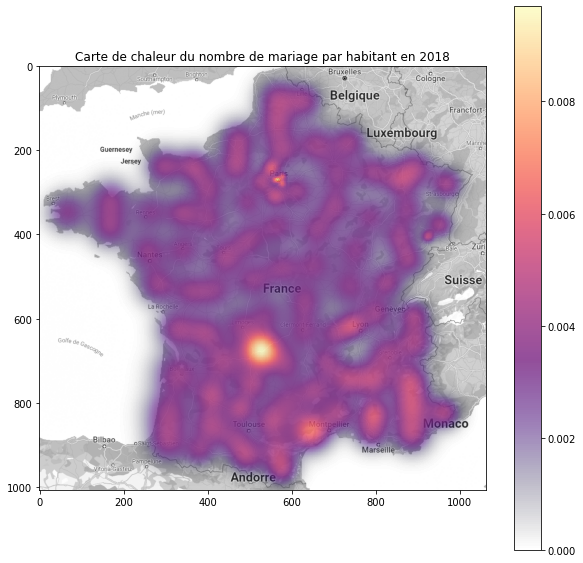

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
y, x = np.mgrid[0:h, 0:w]
z = np.load("./map-data/heatmap-absolute-sigma-radius-normalize-pop.npy")
c = ax.pcolormesh(x, y , z, cmap=mycmap_magma)
fig.colorbar(c, ax=ax)
ax.set_title("Carte de chaleur du nombre de mariage par habitant en 2018")
ax.imshow(I)
plt.show()